In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Load CSV files
customers = pd.read_csv('/content/drive/MyDrive/archive/olist_customers_dataset.csv')
orders = pd.read_csv('/content/drive/MyDrive/archive/olist_orders_dataset.csv')
order_items = pd.read_csv('/content/drive/MyDrive/archive/olist_order_items_dataset.csv')
payments = pd.read_csv('/content/drive/MyDrive/archive/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/content/drive/MyDrive/archive/olist_order_reviews_dataset.csv')
products = pd.read_csv('/content/drive/MyDrive/archive/product_category_name_translation.csv')
sellers = pd.read_csv('/content/drive/MyDrive/archive/olist_sellers_dataset.csv')
geolocation = pd.read_csv('/content/drive/MyDrive/archive/olist_geolocation_dataset.csv')
category_translation = pd.read_csv('/content/drive/MyDrive/archive/product_category_name_translation.csv')


# --- Merging ---
customer_orders = pd.merge(orders, customers, on='customer_id', how='left')
order_items_merged = pd.merge(customer_orders, order_items, on='order_id', how='left')
order_items_merged = pd.merge(order_items_merged, reviews[['order_id', 'review_score', 'review_creation_date']],
                              on='order_id', how='left')


# --- Feature Engineering ---

# Convert dates
order_items_merged['order_purchase_timestamp'] = pd.to_datetime(order_items_merged['order_purchase_timestamp'], format='%d-%m-%Y %H:%M')
order_items_merged['review_creation_date'] = pd.to_datetime(order_items_merged['review_creation_date'], format='%d-%m-%Y %H:%M', errors='coerce')

# Flag low review (return abuse proxy)
order_items_merged['low_review_flag'] = order_items_merged['review_score'].apply(lambda x: 1 if x <= 2 else 0)

# Recent Order Count (Last 30 Days from max date)
max_date = order_items_merged['order_purchase_timestamp'].max()
cutoff_date = max_date - timedelta(days=30)

recent_orders = order_items_merged[order_items_merged['order_purchase_timestamp'] >= cutoff_date]
recent_order_counts = recent_orders.groupby('customer_unique_id')['order_id'].nunique().reset_index()
recent_order_counts.columns = ['customer_unique_id', 'recent_order_count_30days']

# Order Streak Days (Last Order - First Order)
order_range = order_items_merged.groupby('customer_unique_id')['order_purchase_timestamp'].agg(['min', 'max']).reset_index()
order_range['order_streak_days'] = (order_range['max'] - order_range['min']).dt.days
order_range['first_order_date'] = order_range['min']

# Complaint Delay (Average Days Between Order and Complaint)
order_items_merged['complaint_delay_days'] = (order_items_merged['review_creation_date'] - order_items_merged['order_purchase_timestamp']).dt.days
complaint_delays = order_items_merged.groupby('customer_unique_id')['complaint_delay_days'].mean().reset_index()
complaint_delays.columns = ['customer_unique_id', 'complaint_delay_avg_days']

# Region (Using ZIP prefix)
region = customers[['customer_unique_id', 'customer_zip_code_prefix']].drop_duplicates()
region.columns = ['customer_unique_id', 'region']

# Basic Aggregated Features
customer_features = order_items_merged.groupby('customer_unique_id').agg({
    'order_id': 'nunique',
    'price': ['sum', 'mean', 'max'],
    'low_review_flag': 'sum'
}).reset_index()

customer_features.columns = [
    'customer_unique_id',
    'total_orders',
    'total_spent',
    'avg_order_value',
    'max_order_value',
    'total_low_reviews'
]

customer_features['low_review_ratio'] = customer_features['total_low_reviews'] / customer_features['total_orders']


# --- Merging Advanced Features ---
customer_features = pd.merge(customer_features, recent_order_counts, on='customer_unique_id', how='left')
customer_features = pd.merge(customer_features, order_range[['customer_unique_id', 'order_streak_days', 'first_order_date']], on='customer_unique_id', how='left')
customer_features = pd.merge(customer_features, complaint_delays, on='customer_unique_id', how='left')
customer_features = pd.merge(customer_features, region, on='customer_unique_id', how='left')

# Fill missing recent orders as 0
customer_features['recent_order_count_30days'].fillna(0, inplace=True)

# View the final feature table
customer_features.head()

/tmp/ipython-input-26-1359810438.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_features['recent_order_count_30days'].fillna(0, inplace=True)


,customer_unique_id,total_orders,total_spent,avg_order_value,max_order_value,total_low_reviews,low_review_ratio,recent_order_count_30days,order_streak_days,first_order_date,complaint_delay_avg_days,region
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,129.90,129.90,0,0.0,0.0,0,2018-05-10 10:56:00,6.0,7787
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,18.90,18.90,0,0.0,0.0,0,2018-05-07 11:11:00,3.0,6053
2,0000f46a3911fa3c0805444483337064,1,69.00,69.00,69.00,0,0.0,0.0,0,2017-03-10 21:05:00,26.0,88115
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,25.99,25.99,0,0.0,0.0,0,2017-10-12 20:29:00,20.0,66812
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,180.00,180.00,0,0.0,0.0,0,2017-11-14 19:45:00,13.0,18040


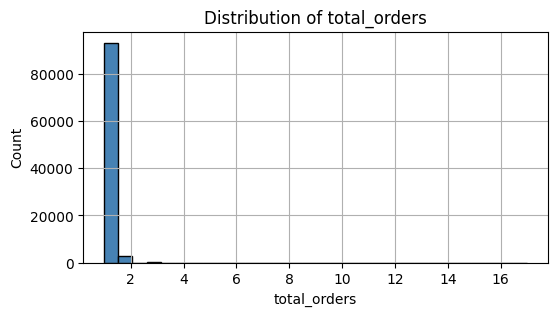

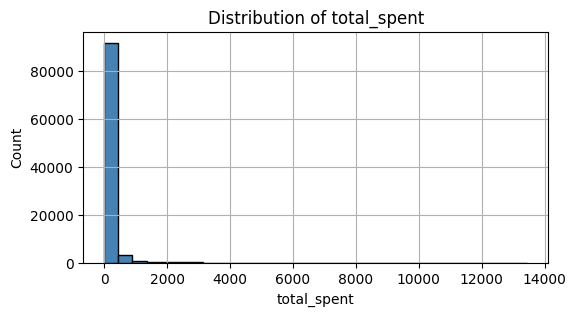

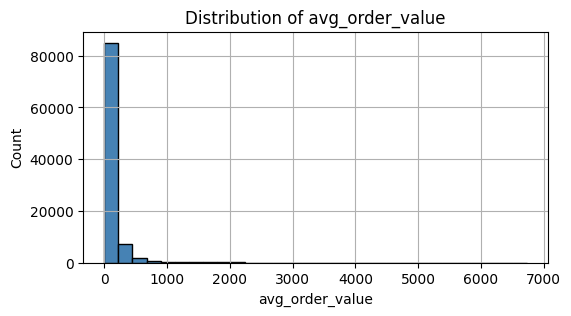

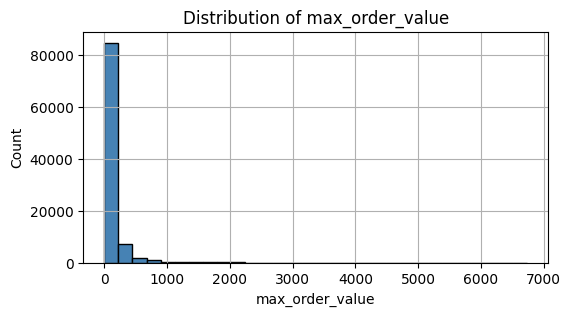

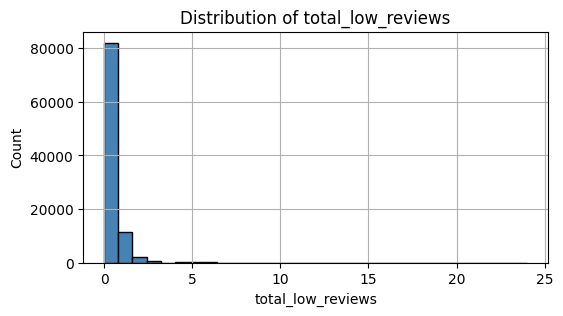

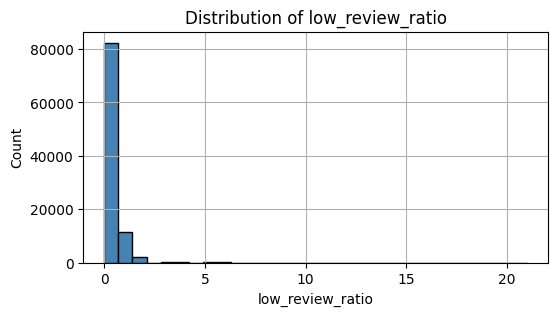

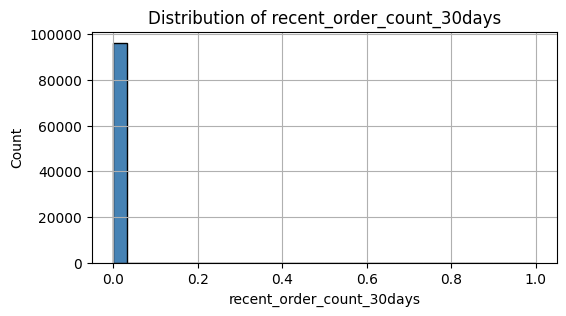

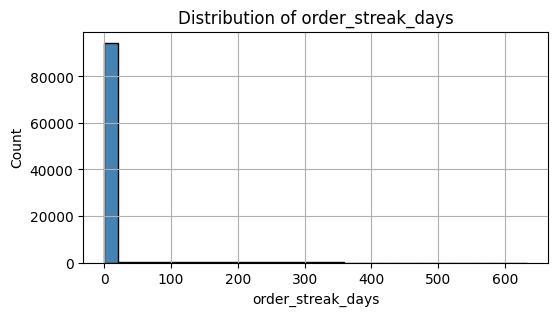

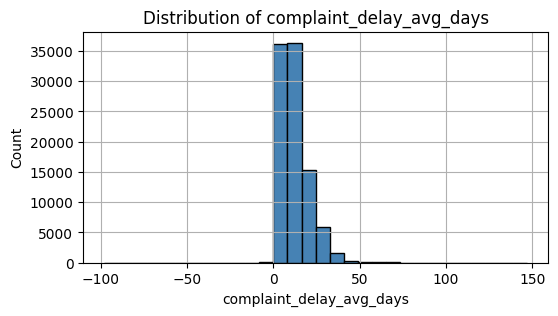

Customers with non-zero low_review_ratio: 14335 / 96350
Percentage: 14.88%


In [ ]:
# Summary statistics
customer_features.describe()

# Missing values check
customer_features.isnull().sum()

# Distribution check for key features
import matplotlib.pyplot as plt

feature_cols = [
    'total_orders', 'total_spent', 'avg_order_value', 'max_order_value',
    'total_low_reviews', 'low_review_ratio', 'recent_order_count_30days',
    'order_streak_days', 'complaint_delay_avg_days'
]

for col in feature_cols:
    plt.figure(figsize=(6, 3))
    plt.hist(customer_features[col], bins=30, color='steelblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

# Check proportion of customers with non-zero low_review_ratio
non_zero_low_review = (customer_features['low_review_ratio'] > 0).sum()
total_customers = customer_features.shape[0]

print(f"Customers with non-zero low_review_ratio: {non_zero_low_review} / {total_customers}")
print(f"Percentage: {round((non_zero_low_review / total_customers) * 100, 2)}%")


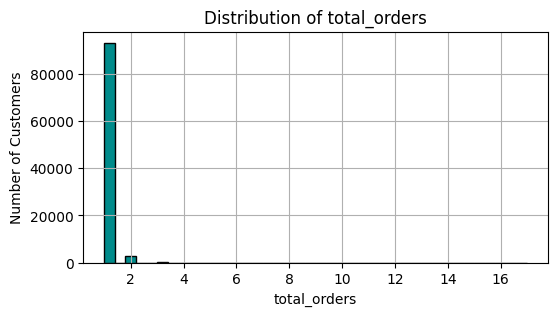

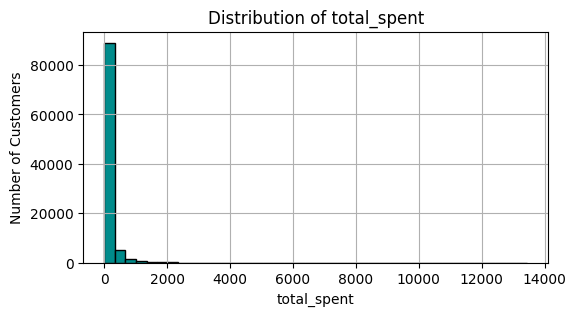

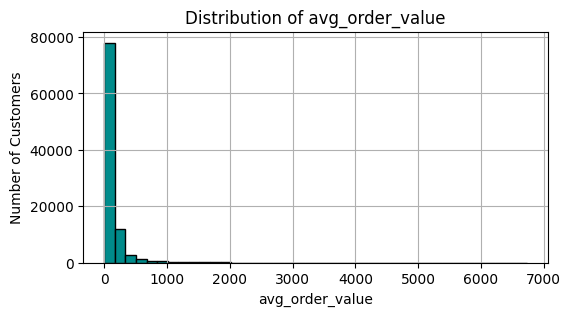

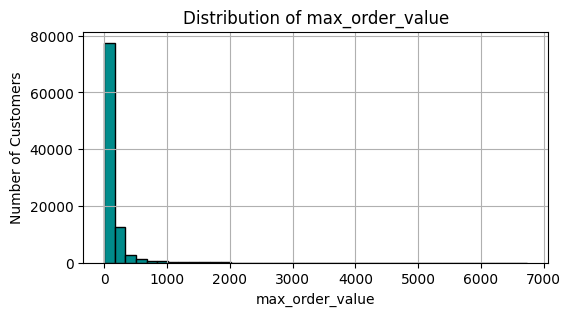

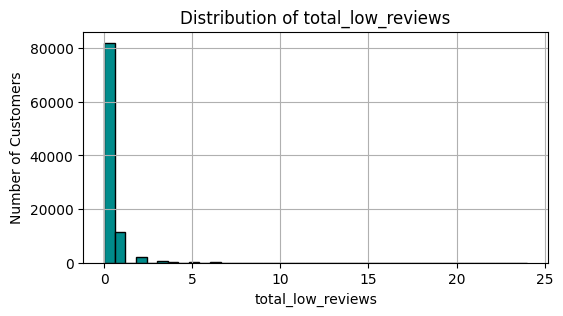

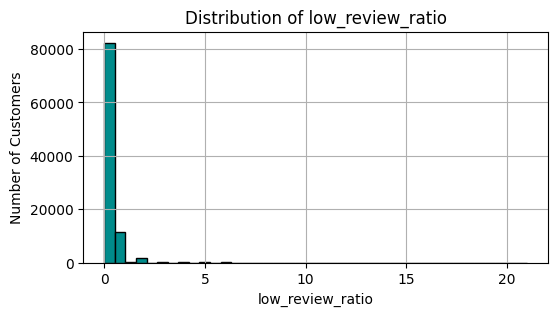

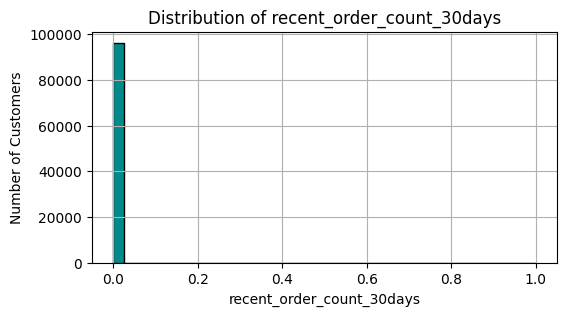

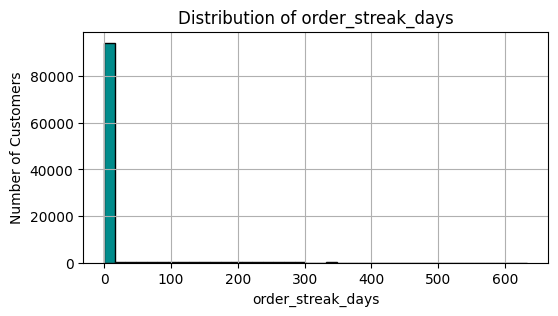

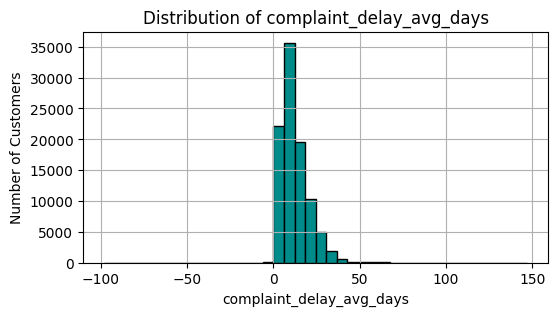

In [ ]:
import matplotlib.pyplot as plt

feature_cols = [
    'total_orders', 'total_spent', 'avg_order_value', 'max_order_value',
    'total_low_reviews', 'low_review_ratio', 'recent_order_count_30days',
    'order_streak_days', 'complaint_delay_avg_days'
]

for col in feature_cols:
    plt.figure(figsize=(6, 3))
    plt.hist(customer_features[col], bins=40, color='darkcyan', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Number of Customers')
    plt.grid(True)
    plt.show()


In [ ]:
# Label customers as high-risk if low_review_ratio >= 0.3
customer_features['risk_label'] = customer_features['low_review_ratio'].apply(
    lambda x: 1 if x >= 0.3 else 0
)

# Check label distribution
print(customer_features['risk_label'].value_counts())


risk_label
0    82021
1    14329
Name: count, dtype: int64


In [ ]:
# Fill missing complaint delays as -1 (means no complaints ever)
customer_features['complaint_delay_avg_days'].fillna(-1, inplace=True)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
customer_features['region_encoded'] = le.fit_transform(customer_features['region'].astype(str))
feature_cols = [
    'total_spent', 'avg_order_value', 'max_order_value',
    'recent_order_count_30days', 'order_streak_days',
    'complaint_delay_avg_days', 'region_encoded'
]

X = customer_features[feature_cols]
y = customer_features['risk_label']



/tmp/ipython-input-7-2187577896.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_features['complaint_delay_avg_days'].fillna(-1, inplace=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Select Top 5 Important Features
selected_features = [
    'complaint_delay_avg_days',
    'avg_order_value',
    'total_spent',
    'max_order_value',
    'region_encoded'
]

# Subset Train/Test with Selected Features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Compute scale_pos_weight (Should be configurable for different companies)
neg_class = sum(y_train == 0)
pos_class = sum(y_train == 1)
scale_pos_weight = neg_class / pos_class

# Train XGBoost with imbalance adjustment
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

xgb_model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_model.fit(X_train_selected, y_train)
xgb_probs = xgb_model.predict_proba(X_test_selected)[:, 1]

# Evaluation using 0.5 threshold (default)
print("XGBoost Classification Report (Default Threshold 0.5):")
print(classification_report(y_test, xgb_model.predict(X_test_selected)))

print("XGBoost ROC AUC Score:", roc_auc_score(y_test, xgb_probs))

# Threshold Tuning (0.3)
threshold = 0.3
xgb_preds = (xgb_probs >= threshold).astype(int)

print("\nXGBoost Classification Report (Threshold 0.3):")
print(classification_report(y_test, xgb_preds))


XGBoost Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       0.91      0.79      0.85     16404
           1       0.33      0.58      0.42      2866

    accuracy                           0.76     19270
   macro avg       0.62      0.68      0.63     19270
weighted avg       0.83      0.76      0.79     19270

XGBoost ROC AUC Score: 0.7317876913924795

XGBoost Classification Report (Threshold 0.3):
              precision    recall  f1-score   support

           0       0.93      0.43      0.59     16404
           1       0.20      0.82      0.32      2866

    accuracy                           0.49     19270
   macro avg       0.57      0.63      0.46     19270
weighted avg       0.82      0.49      0.55     19270



                    feature  importance
0  complaint_delay_avg_days    0.506423
1           avg_order_value    0.162544
2               total_spent    0.144082
3           max_order_value    0.096685
4            region_encoded    0.090266


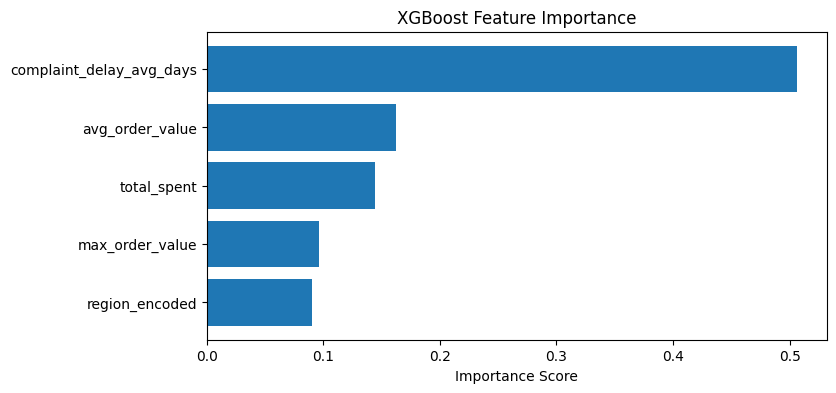

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get importance scores
importance_df = pd.DataFrame({
    'feature': selected_features,  # Use selected_features for feature names
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Display importance
print(importance_df)

# Plot
plt.figure(figsize=(8, 4))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(f"Classification Report for Fold {fold}:")
print(classification_report(y_test, y_pred, digits=3))


Classification Report for Fold 6:
              precision    recall  f1-score   support

           0      0.888     0.945     0.915     16404
           1      0.500     0.317     0.388      2866

    accuracy                          0.851     19270
   macro avg      0.694     0.631     0.652     19270
weighted avg      0.830     0.851     0.837     19270



In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.0 MB/s eta 0:00:00


In [ ]:
# Define Risk Bucketing Function
def assign_risk_bucket(score):
    if score >= 0.7:
        return 'High Risk'
    elif score >= 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Prepare Risk Score DataFrame (XGBoost)
risk_scores_df = X_test.copy()
risk_scores_df['actual_label'] = y_test.values
risk_scores_df['xgb_risk_score'] = xgb_probs  # Assuming xgb_probs = model.predict_proba(X_test)[:, 1]
risk_scores_df['predicted_label'] = (xgb_probs >= 0.3).astype(int)  # Optional: Binary prediction
risk_scores_df['risk_bucket'] = risk_scores_df['xgb_risk_score'].apply(assign_risk_bucket)

# View Sample Output
print(risk_scores_df[['xgb_risk_score', 'predicted_label', 'risk_bucket']].head())

# Optional: Export to CSV
risk_scores_df.to_csv("xgb_risk_scores_with_buckets_final.csv", index=False)


    xgb_risk_score  predicted_label  risk_bucket
6         0.654025                1  Medium Risk
8         0.719082                1    High Risk
28        0.758363                1    High Risk
34        0.382117                1     Low Risk
38        0.324114                1     Low Risk


100%|===================| 19266/19270 [00:44<00:00]       

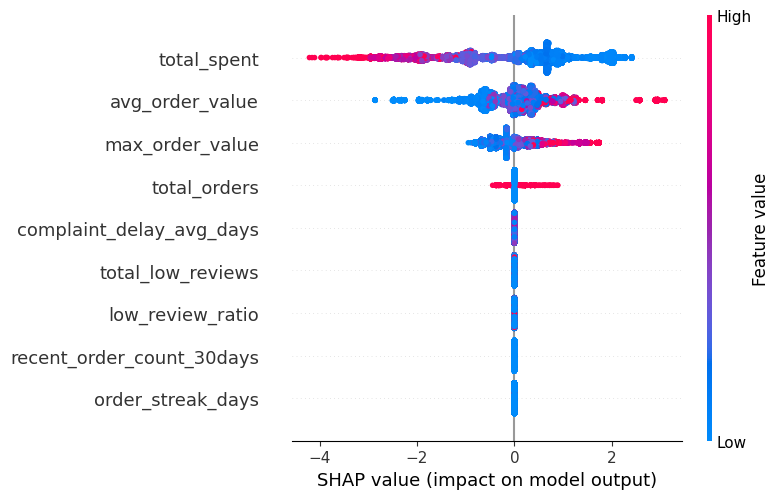

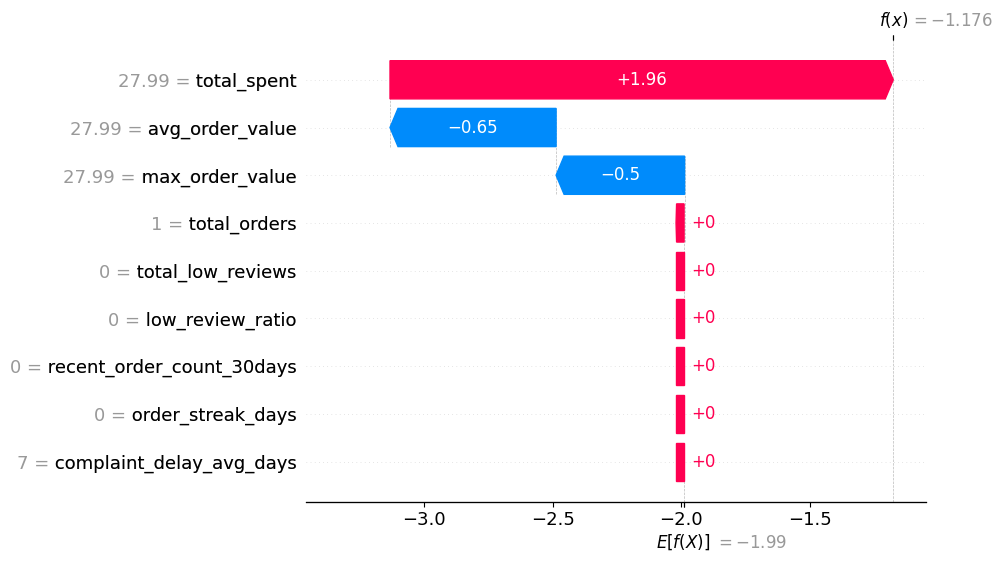

In [ ]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model, X_train)

# Explain predictions on test set
shap_values = explainer(X_test)

# Plot SHAP summary (global feature importance)
shap.summary_plot(shap_values, X_test)

# Plot SHAP explanation for 1 specific customer (example index 0)
shap.plots.waterfall(shap_values[0])


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
import numpy as np

models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

results = {}

# Imputer: Fill NaNs with median value (re-initialize to ensure it's fitted on the correct data)
imputer = SimpleImputer(strategy='median')
X_train_selected_imputed = imputer.fit_transform(X_train_selected)
X_test_selected_imputed = imputer.transform(X_test_selected)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    if model_name == 'LogisticRegression':
        model.fit(X_train_selected_imputed, y_train)
        probs = model.predict_proba(X_test_selected_imputed)[:, 1]
    else:
        model.fit(X_train_selected, y_train)
        probs = model.predict_proba(X_test_selected)[:, 1]


    # ROC AUC
    auc = roc_auc_score(y_test, probs)

    # Threshold tuning at 0.3
    preds = (probs >= 0.3).astype(int)

    print(f"{model_name} ROC AUC Score: {auc:.4f}")
    print(f"{model_name} Classification Report (Threshold 0.3):\n")
    print(classification_report(y_test, preds))


Training XGBoost...
XGBoost ROC AUC Score: 0.7318
XGBoost Classification Report (Threshold 0.3):

              precision    recall  f1-score   support

           0       0.93      0.43      0.59     16404
           1       0.20      0.82      0.32      2866

    accuracy                           0.49     19270
   macro avg       0.57      0.63      0.46     19270
weighted avg       0.82      0.49      0.55     19270


Training RandomForest...
RandomForest ROC AUC Score: 0.6993
RandomForest Classification Report (Threshold 0.3):

              precision    recall  f1-score   support

           0       0.89      0.86      0.88     16404
           1       0.33      0.39      0.36      2866

    accuracy                           0.79     19270
   macro avg       0.61      0.63      0.62     19270
weighted avg       0.81      0.79      0.80     19270


Training LogisticRegression...
LogisticRegression ROC AUC Score: 0.7106
LogisticRegression Classification Report (Threshold 0.3):

 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lime --quiet
import sys
import os
os.execv(sys.executable, ['python'] + sys.argv)


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Low Risk', 'High Risk'],
    mode='classification'
)

# Choose an instance to explain (e.g., the first test customer)
idx = 0
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[idx],
    predict_fn=xgb_model.predict_proba
)

# Show explanation
exp.show_in_notebook(show_table=True)
